In [15]:
'''
SCRIPT PER PROVARE un classificatore con kfold sul test set
'''

import time
t_orig = time.process_time()
last_time = 0

#import codecs
#import csv
#import argparse
import os
import numpy as np

#from time import time
from dill import dill
from sklearn.metrics import f1_score, classification_report, accuracy_score, recall_score, precision_score
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import svm #cross_validation,
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.tree.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sqlite3
import pandas as pd

# modulo per confrontare il risultato delle regex
# richiede entrambi i db già etichettati
import tortellino_parmigiano 
import crea_db


import evaluation_report # stampa confusion_matrix e altro
from text_tokenizer import get_tokenizer 
from nltk.stem.snowball import ItalianStemmer

import warnings
warnings.simplefilter("ignore")
print('OK')

OK


In [2]:
#import timeit
# decorator to time the function
# this function should be assigned to an object with parameters
# and then passed to timeit
#def wrapper(func, *args, **kwargs):
#    def wrapped():
#        return func(*args, **kwargs)
#    return wrapped


DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI
DB_NAME = 'test_manina.sqlite'

# Load sqlite db training set annotato a mano

con = sqlite3.connect(os.path.join(DATA_FOLDER, DB_NAME))
training_pd = pd.read_sql_query("SELECT * from test", con)

ita_stopwords = set(stopwords.words('italian'))
ita_stemmer = ItalianStemmer()
ita_stemming = ita_stemmer.stem

print('Time to load DB: ', time.process_time()-last_time)
last_time = time.process_time()

def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    #doc = map(ita_stemming, doc)
    #doc = [ita_stemmer.stem(a) for a in doc]
    temp = ''
    for par in doc:
        temp = '{} {}'.format(temp, ita_stemming(par))
    return temp
#building data and trying some features selection

def unisci_canali(o,c):
    o = o.replace('O:', '')
    c = c.replace('C:', '')
    return '{} {}'.format(o,c)


training_corretto = pd.DataFrame()
# Unisce i canali, tokenizza, fa stemming, e mette la conversazione in un dataframe
training_corretto['trascritto'] = pd.Series(map(get_tokenizer, [ unisci_canali(
            row['testo_operatore'],row['testo_cliente']) for _,row in training_pd.iterrows() ]))

print('Time to join conversations: ', time.process_time()-last_time)
last_time = time.process_time()

features = ['attivazione', 'canone_rai','cessazione','contratto','credito','domiciliazione','fatturazione',
           'gr_invito_a_chiamare','non_di_competenza','richiamate']
# aggiunge le colonne etichette al dataframe
training_corretto[features] = training_pd[features]

# Set seed
generatore_random = np.random.RandomState(seed=5)
#print('Rand seed:', generatore_random.seed)

# separa il validation set
msk = generatore_random.rand(len(training_corretto)) < 0.85 # soglia dello split: il 15% va nel validation
validation_set = training_corretto[~msk]
training_set = training_corretto[msk]

print('Time to create validation set: ', time.process_time()-last_time)
last_time = time.process_time()

print('Items in the training set:', training_set.shape)
# il validation set va usato solo alla fine
print('Items in the validation set:', validation_set.shape)
print('ok')

Time to load DB:  3.041657495
Time to join conversations:  7.623455488
Time to create validation set:  0.011302338000000134
Items in the training set: (344, 11)
Items in the validation set: (60, 11)
ok


In [14]:
#training_set[features].head(10)

,attivazione,canone_rai,cessazione,contratto,credito,domiciliazione,fatturazione,gr_invito_a_chiamare,non_di_competenza,richiamate
0,0,1,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,0,1,0,0
9,0,0,0,0,1,0,0,0,1,0
10,0,0,0,1,1,0,0,0,0,0


In [13]:
# set up ML models
n_splits = 5
# setta il parametro C da testare
combination = [25]

class BorsoneModello:
    'Common class for all models: saves count_vect, svm'
    def __init__(self, count_vect):
        # una lista per ogni fold
        # una sottolista per ogni categoria
        self.algo = []
        self.count_vect = count_vect

        
# ricostruisce gli indici partendo da 0
etichette_train_set = training_set[features].reindex()
# fa la matrice document-term
# questa deve essere la stessa matrice del training e del test
count_vect = CountVectorizer()
matrix_countvect = count_vect.fit_transform(training_set['trascritto'])

# crea il modello da salvare in pickler
zainone = BorsoneModello(count_vect) 

# crea un classificatore per ogni valore di c
for c in combination:
    algo = OneVsRestClassifier(LinearSVC(C=c), n_jobs=-1)
    # crea una lista di classificatori a votazione
    models = [algo]*n_splits

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    #print(folds)
    #print(training_set.head(2)['contratto'])
    
    #crea il vettore in cui salveremo gli score
    average = np.zeros(n_splits)
    # kfold: each classificato is evalutaed against its test set fold
    # folds returns the row *indeces*
    for i, (train, test) in enumerate(folds.split(training_set)):
        # preparation
        X_train = matrix_countvect[train]
        Y_train = etichette_train_set.iloc[train]
        X_test = matrix_countvect[test]
        Y_test = etichette_train_set.iloc[test]

        # TfIdf Transform
        X_train = TfidfTransformer(use_idf=True).fit_transform(X_train)
        X_test = TfidfTransformer(use_idf=True).fit_transform(X_test)
    
        # learns from data
        models[i].fit(X_train, Y_train)
        # predicts on test set
        y = models[i].predict(X_test)
        # evaluate
        score = f1_score(Y_test, y, average='weighted')
        #print('Score f1 del modello {}: {}'.format(i, score))
        average[i] = score
        
        print('Score f1 del modello {}: {}'.format(i, score))
        print(classification_report(Y_test, y, target_names=features))

        
    # salva il modello del fold
    zainone.algo = models
    print('C:', c)
    print('La media e\':', average.mean())
    print('Stdev:', average.std())

Score f1 del modello 0: 0.46180122907395627
                      precision    recall  f1-score   support

         attivazione       0.67      0.29      0.40        14
          canone_rai       1.00      0.44      0.62        18
          cessazione       0.00      0.00      0.00         2
           contratto       0.83      0.31      0.45        16
             credito       0.67      0.80      0.73        25
      domiciliazione       0.00      0.00      0.00         3
        fatturazione       0.36      0.31      0.33        16
gr_invito_a_chiamare       0.00      0.00      0.00         5
   non_di_competenza       1.00      0.20      0.33        10
          richiamate       0.00      0.00      0.00         1

         avg / total       0.66      0.40      0.46       110

Score f1 del modello 1: 0.5377602379318233
                      precision    recall  f1-score   support

         attivazione       0.75      0.25      0.38        12
          canone_rai       1.00      0.33

In [52]:
# USE VotingClassifier + CHI2

# set up ML models

n_splits = 5
# c values to test
combination = [20]

# ricostruisce gli indici partendo da 0
#etichette_train_set = training_set[features].reindex()

# come deve essere: 
# OneVsRest 
# a votazione tanti quanti sono i folds

# ricostruisce gli indici partendo da 0
etichette_train_set = training_set[features].reindex()
# fa la matrice document-term
# questa deve essere la stessa matrice del training e del test
count_vect = CountVectorizer()
matrix_countvect = count_vect.fit_transform(training_set['trascritto'])

def spurga_svm(n_svm, combination, n_splits):
    for c in combination:
        for s in range(n_splits):
            yield [LinearSVC(C=c)] * n_svm

def rapporto(divisore):
    def soglia(l):
        if l/divisore < 0.5:
            return 0
        else:
            return 1
    
    return soglia

giudice_supremo = rapporto(n_splits)

model_dispenser = spurga_svm(etichette_train_set.shape[1], combination, n_splits)

class BorsoneModello:
    'Common class for all models: saves chi2, svm'
    def __init__(self, count_vect):
        # una lista per ogni fold
        # una sottolista per ogni categoria
        self.chi2 = []
        self.algo = []
        self.count_vect = count_vect
        self.counter = 0
    def chi2_populate(self, chi2_list):
        self.chi2.append(chi2_list)
        self.counter += 1
    def algo_populate(self, algo_list):
        self.algo.append(algo_list)
        self.counter += 1
    
print('Time to create training set: ', time.process_time()-last_time)
last_time = time.process_time()

nomi_etichette = list(validation_set[features].columns.values)

#il count_vect e' uguale per tutti i fold
zainone = BorsoneModello(count_vect) 

# crea un classificatore per ogni valore di c
for c in combination:
    #algo = OneVsRestClassifier(LinearSVC(C=c), n_jobs=-1)
    # crea una lista di classificatori a votazione
    #models = [algo]*n_splits

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    #print(folds)
    #print(training_set.head(2)['contratto'])
    
    #crea il vettore in cui salveremo gli score
    average = np.zeros(n_splits)
    
    #y_voted = np.zeros((training_set.shape[0], etichette_train_set.shape[1]))
    # crea la lista dove salvare i modelli
    # kfold: each classificato is evalutaed against its test set fold
    # folds returns the row *indeces*
    for i, (train, test) in enumerate(folds.split(training_set)):
        # preparation
        X_train = matrix_countvect[train]
        Y_train = etichette_train_set.iloc[train]
        X_test = matrix_countvect[test]
        Y_test = etichette_train_set.iloc[test]
        
        # chi2
        # la matrice filtrata, una per classe
        X_chi2 = [] 
        X_test_chi2 = []
        #k = (4000,1500,2500,5000,2500,2500,1500,3000,3000,5000)
        #k = (300,300,300,300,300,300,300,300,300,300)
        #scores = []
        feat = [] # il chi2
        # matrice dove salvare i predicted
        y = np.zeros((Y_test.shape[0], etichette_train_set.shape[1]))
        
        for g in range(Y_train.shape[1]):
            # oggetto chi2 che salvo in lista
            feat.append(SelectKBest(chi2, k = 300))#k[g])) 
            # fitto e salvo nella lista la matrice filtrata
            X_chi2.append(feat[g].fit_transform(X_train,Y_train.iloc[:,g])) 
            # test set
            X_test_chi2.append(feat[g].transform(X_test[g]))
            #scores.append(feat[i].pvalues_)
            #chi_k.append(feat[i].get_support(indices=True))
        
        # TfIdf Transform # attenzione fit transform
        for g in range(Y_train.shape[1]):
            X_chi2[g] = TfidfTransformer(use_idf=True).fit_transform(X_chi2[g])
            X_test_chi2[g] = TfidfTransformer(use_idf=True).fit_transform(X_test_chi2[g])
        
        # creo un svm per ogni classe
        models = next(model_dispenser)
        
        
        # per ogni classe
        for g in range(len(models)):
            # fitto
            models[g].fit(X_chi2[g], Y_train.iloc[:,g]) #texts[g]
            # predicts on test set
            y[:,g] = models[g].predict(X_test_chi2[g])
        
        # evaluate
        score = f1_score(Y_test, y, average='weighted')
        print('f1_score:', score)
        print('Score f1 del modello {}: {}'.format(i, score))
        average[i] = score
        print(classification_report(Y_test, y, target_names=nomi_etichette))

        # at last, save all the objects
        # chi2
        zainone.chi2_populate(feat)
        # svm
        zainone.algo_populate(models)
    
    # votazione
    #y_voted = pd.DataFrame(y.sum(axis=2), columns=nomi_etichette)
    #y_voted = y_voted.applymap(giudice_supremo)
    
    print('C:', c)
    print('La media e\':', average.mean())
    print('Stdev:', average.std())
print('Time to create all models: ', time.process_time()-last_time)
last_time = time.process_time()

Time to create training set:  0.4327085730000064
f1_score: 0.0
Score f1 del modello 0: 0.0
                      precision    recall  f1-score   support

         attivazione       0.00      0.00      0.00        14
          canone_rai       0.00      0.00      0.00        18
          cessazione       0.00      0.00      0.00         2
           contratto       0.00      0.00      0.00        16
             credito       0.00      0.00      0.00        25
      domiciliazione       0.00      0.00      0.00         3
        fatturazione       0.00      0.00      0.00        16
gr_invito_a_chiamare       0.00      0.00      0.00         5
   non_di_competenza       0.00      0.00      0.00        10
          richiamate       0.00      0.00      0.00         1

         avg / total       0.00      0.00      0.00       110

f1_score: 0.0102127659574
Score f1 del modello 1: 0.010212765957446808
                      precision    recall  f1-score   support

         attivazione       0

In [53]:
# USE VotingClassifier WITHOUT CHI2

# set up ML models

n_splits = 5
# c values to test
combination = [20]

# ricostruisce gli indici partendo da 0
#etichette_train_set = training_set[features].reindex()

# come deve essere: 
# OneVsRest 
# a votazione tanti quanti sono i folds

# ricostruisce gli indici partendo da 0
etichette_train_set = training_set[features].reindex()
# fa la matrice document-term
# questa deve essere la stessa matrice del training e del test
count_vect = CountVectorizer()
matrix_countvect = count_vect.fit_transform(training_set['trascritto'])

def spurga_svm(n_svm, combination, n_splits):
    for c in combination:
        for s in range(n_splits):
            yield [LinearSVC(C=c)] * n_svm

def rapporto(divisore):
    def soglia(l):
        if l/divisore < 0.5:
            return 0
        else:
            return 1
    
    return soglia

giudice_supremo = rapporto(n_splits)

model_dispenser = spurga_svm(etichette_train_set.shape[1], combination, n_splits)

class BorsoneModello:
    'Common class for all models: saves chi2, svm'
    def __init__(self, count_vect):
        # una lista per ogni fold
        # una sottolista per ogni categoria
        self.algo = []
        self.count_vect = count_vect
        self.counter = 0
    def algo_populate(self, algo_list):
        self.algo.append(algo_list)
        self.counter += 1
    
print('Time to create training set: ', time.process_time()-last_time)
last_time = time.process_time()

nomi_etichette = list(validation_set[features].columns.values)

#il count_vect e' uguale per tutti i fold
zainone = BorsoneModello(count_vect) 

# crea un classificatore per ogni valore di c
for c in combination:
    #algo = OneVsRestClassifier(LinearSVC(C=c), n_jobs=-1)
    # crea una lista di classificatori a votazione
    #models = [algo]*n_splits

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    #print(folds)
    #print(training_set.head(2)['contratto'])
    
    #crea il vettore in cui salveremo gli score
    average = np.zeros(n_splits)
    
    # crea la lista dove salvare i modelli
    # kfold: each classificato is evalutaed against its test set fold
    # folds returns the row *indeces*
    for i, (train, test) in enumerate(folds.split(training_set)):
        # preparation
        X_train = matrix_countvect[train]
        Y_train = etichette_train_set.iloc[train]
        X_test = matrix_countvect[test]
        Y_test = etichette_train_set.iloc[test]
        
        # TfIdf Transform # attenzione fit transform
        X_train = TfidfTransformer(use_idf=True).fit_transform(X_train)
        X_test = TfidfTransformer(use_idf=True).fit_transform(X_test)
        
        # creo un svm per ogni classe
        models = next(model_dispenser)
        y = np.zeros((Y_test.shape[0], etichette_train_set.shape[1]))
        
        # per ogni classe
        for g in range(len(models)):
            # fitto
            models[g].fit(X_train, Y_train.iloc[:,g])
            # predicts on test set
            y[:,g] = models[g].predict(X_test)
        
        # evaluate
        score = f1_score(Y_test, y, average='weighted')
        print('f1_score:', score)
        print('Score f1 del modello {}: {}'.format(i, score))
        average[i] = score
        print(classification_report(Y_test, y, target_names=nomi_etichette))

        # at last, save all the objects
        # svm
        zainone.algo_populate(models)
    
    print('C:', c)
    print('La media e\':', average.mean())
    print('Stdev:', average.std())
print('Time to create all models: ', time.process_time()-last_time)
last_time = time.process_time()

    # votazione
    #y_voted = pd.DataFrame(y.sum(axis=2), columns=nomi_etichette)
    #y_voted = y_voted.applymap(giudice_supremo)

Time to create training set:  0.3266428029999986
f1_score: 0.461801229074
Score f1 del modello 0: 0.46180122907395627
                      precision    recall  f1-score   support

         attivazione       0.67      0.29      0.40        14
          canone_rai       1.00      0.44      0.62        18
          cessazione       0.00      0.00      0.00         2
           contratto       0.83      0.31      0.45        16
             credito       0.67      0.80      0.73        25
      domiciliazione       0.00      0.00      0.00         3
        fatturazione       0.36      0.31      0.33        16
gr_invito_a_chiamare       0.00      0.00      0.00         5
   non_di_competenza       1.00      0.20      0.33        10
          richiamate       0.00      0.00      0.00         1

         avg / total       0.66      0.40      0.46       110

f1_score: 0.537760237932
Score f1 del modello 1: 0.5377602379318233
                      precision    recall  f1-score   support

    

In [9]:
######################## learning curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

(344, 5346)
(344, 10)


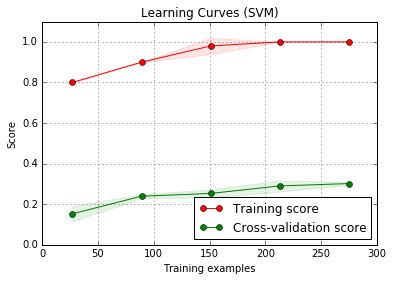

In [10]:
estimators = OneVsRestClassifier(LinearSVC(C=c))
#svm_all = VotingClassifier(estimators)

title = "Learning Curves (SVM)"
print(matrix_countvect.shape)
print(etichette_train_set.shape)
plot_learning_curve(estimators, title, matrix_countvect, etichette_train_set, (0, 1.1), cv=5, n_jobs=-1)
plt.show()

In [17]:
# Now compare with the validatino set! NOT CHI2

Y_validation = validation_set[features].reindex()
matrix_countvect = zainone.count_vect.transform(validation_set['trascritto']) #possible problem on fit_transform

X_validation = TfidfTransformer(use_idf=True).fit_transform(matrix_countvect)

#create numpy matrix
Y_predicted = np.zeros(Y_validation.shape)

for i, model in enumerate(zainone.algo):
    y = model.predict(X_validation)
    Y_predicted = Y_predicted + y

Y_predicted = Y_predicted / n_splits

def soglia(l):
    if l < 0.5:
        return 0
    else:
        return 1
applica_soglia = np.vectorize(soglia)

Y_predicted = applica_soglia(Y_predicted)

nomi_etichette = list(validation_set[features].columns.values)
#evaluation_report.print_evaluation(Y_true, Y_predicted)
print(classification_report(Y_validation, Y_predicted, target_names=nomi_etichette))
print('#n of items predicted in each category')
for i in range(Y_validation.shape[1]):
    print(nomi_etichette[i], np.sum(Y_predicted[:,i]))
    

print('\n')
print('accuracy', accuracy_score(Y_validation, Y_predicted))
print('precision micro',precision_score(Y_validation, Y_predicted, average='micro') )
print('recall micro',recall_score(Y_validation, Y_predicted, average='micro'))
print('f1 micro', f1_score(Y_validation, Y_predicted, average='micro'))
print('precision macro', precision_score(Y_validation, Y_predicted, average='macro') )
print('recall macro', recall_score(Y_validation, Y_predicted, average='macro'))
print('f1 macro', f1_score(Y_validation, Y_predicted, average='macro'))

                      precision    recall  f1-score   support

         attivazione       0.57      0.36      0.44        11
          canone_rai       0.75      0.67      0.71         9
          cessazione       0.00      0.00      0.00         0
           contratto       0.40      0.17      0.24        12
             credito       0.50      0.67      0.57        15
      domiciliazione       1.00      0.33      0.50         3
        fatturazione       0.80      0.52      0.63        23
gr_invito_a_chiamare       0.00      0.00      0.00         2
   non_di_competenza       0.67      0.25      0.36         8
          richiamate       0.00      0.00      0.00         0

         avg / total       0.63      0.45      0.50        83

#n of items predicted in each category
attivazione 7
canone_rai 8
cessazione 0
contratto 5
credito 20
domiciliazione 1
fatturazione 15
gr_invito_a_chiamare 0
non_di_competenza 3
richiamate 0


accuracy 0.216666666667
precision micro 0.627118644068
recal

Grid Search celle larghe:

Best score: 0.464

Best parameters set:

clf__estimator__C: 1

tfidf__use_idf: True

vect__max_df: 0.5

vect__max_features: 1000

GRID SEARCH 2:

done in 822.022s
Best score: 0.488
Best parameters set:
	clf__estimator__C: 1.5
	vect__max_df: 0.5
	vect__max_features: 1500
    
GRID SEARCH 3:
done in 935.240s
Best score: 0.480
Best parameters set:
	clf__estimator__C: 10
	vect__max_features: 2500
	vect__min_df: 0
    
    
GS 4:
Best score: 0.488
Best parameters set:
	clf__estimator__C: 9
	vect__max_df: 0.5
	vect__max_features: 1500
	vect__min_df: 0


Best score: 0.471
Best parameters set:
	clf__estimator__C: 12
    
done in 1479.661s
Best score: 0.473
Best parameters set:
	clf__estimator__C: 18
    
done in 1254.545s
Best score: 0.481
Best parameters set:
	clf__estimator__C: 18

In [ ]:
import pandas as pd
score_matrix = gs.cv_results_
df = pd.DataFrame(score_matrix)
df

In [ ]:
# controlla se esiste il modello per evitare di ricrearlo ogni volta
if False: #os.path.exists(os.path.join(DATA_FOLDER, 'OneVsRestClassifier')):
    with open(os.path.join(DATA_FOLDER, 'OneVsRestClassifier'), mode='rb') as modelfile:
        model = dill.load(modelfile)

else:
    model = pipeline.fit(texts, Y)
    print('Modello creato, verifico il test set')


    with open(os.path.join(DATA_FOLDER, 'OneVsRestClassifier'), mode='wb') as modelfile:
        dill.dump(model, modelfile)

In [ ]:
# importo il test set per la valutazione del modello
unito_test = []
names_test = []
test_texts = list()
test_labels = list()
#raise SystemExit

# load test data
# carica il test set
with codecs.open(os.path.join(DATA_FOLDER, test_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)
    print(etichette)
    for row in reader:
        # load documents
        test_texts.append(row[1]+row[2].replace('#O:', '').replace('#C:', ''))
        # load names
        names_test.append(row[0])
        # load labels
        test_labels.append(list(map(lambda x: int(x),row[-10:])))

In [ ]:
Y_test = np.array(test_labels)
# apply model to data
predicted_labels = model.predict(test_texts) #np_array

# print evaluation report
evaluation_report.print_evaluation(Y_test, predicted_labels)
for i in range(predicted_labels.shape[1]):
    print(etichette[i], np.sum(predicted_labels[:,i]))
print('Decision function: ')

scores = model.decision_function(test_texts) #np_array


In [ ]:
# score della cat credito 
cred_score = scores[:,4]
cred_pred = predicted_labels[:,4]
#print(len(cred_score), cred_pred)

positive = cred_score[cred_pred == 1]
neg = cred_score[cred_pred == 0]
#print(positive)
print('media score positivi predetti:   ', positive.mean())
print('media score negativi predetti:   ', neg.mean())
print('std score positivi predetti:     ', positive.std())
print('std score negativi predetti:     ', neg.std())

In [ ]:
# confronto gli score dei doc annotati a mano con quelli assegnati dal modello
cred_score = scores[:,4]
cred_ammano = Y_test[:,4]
#print(len(cred_score), cred_ammano)

positive_ammano = cred_score[cred_ammano == 1]
neg_ammano = cred_score[cred_ammano == 0]
print(sum(cred_ammano), len(positive_ammano))
print('media score positivi:   ' , positive_ammano.mean())
print('media score negativi:   ', neg_ammano.mean())
print('std score positivi:     ', positive_ammano.std())
print('std score negativi:     ', neg_ammano.std())